## Imports

In [1]:
import os
import sunpy.map
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from typing import Tuple, Dict
from skimage.transform import resize  # Importar resize de scikit-image

##  Ruta a las IMG

In [2]:
# Ruta base a tus imágenes
data= "/home/alyonaivanova/personal/SOLAR/data/multichannel_SDO_AIA/"
print(f"Files in directory: {os.listdir(data)}")

Files in directory: ['171.0Å', '131.0Å', '211.0Å', '1700.0Å', '304.0Å', '4500.0Å', '335.0Å', '1600.0Å', '193.0Å']


In [3]:
channel_properties = {
    "131.0Å": {"cmap": "Blues", "description": "10 million K (Flare Plasma)"},
    "171.0Å": {"cmap": "YlGnBu", "description": "1 million K (Quiet Corona)"},
    "193.0Å": {"cmap": "Oranges", "description": "1.25 million K (Active Corona)"},
    "211.0Å": {"cmap": "Reds", "description": "2 million K (Hot Corona)"},
    "304.0Å": {"cmap": "PuRd", "description": "50,000 K (Chromosphere/Transition Region)"},
    "335.0Å": {"cmap": "Purples", "description": "2.5 million K (Active Region Corona)"},
    "1600.0Å": {"cmap": "pink", "description": "6,000 K (Transition Region)"},
    "1700.0Å": {"cmap": "Greys", "description": "5,000 K (Photosphere)"},
    "4500.0Å": {"cmap": "coolwarm", "description": "6,000 K (Photosphere Continuum)"}
}

In [4]:
def load_fits_data(channel_dir: str) -> Tuple[np.ndarray, dict]:
    """
    Load FITS data and metadata from the specified channel directory.

    Args:
        channel_dir (str): Directory containing the FITS files.

    Returns:
        Tuple[np.ndarray, dict]: A tuple containing the image data and metadata.
    """
    fits_files = [f for f in os.listdir(channel_dir) if f.endswith(".fits")]
    if not fits_files:
        raise FileNotFoundError(f"No FITS files found in directory: {channel_dir}")
    
    fits_path = os.path.join(channel_dir, fits_files[0])
    aia_map = sunpy.map.Map(fits_path)
    return aia_map.data, aia_map.meta


##  **Creacion de la Mascara**

Observamos que los pixeles afuera del disco solar solo generaran ruido, entonces para
solucionar est voamos a implementar una máscara circular para eliminar los píxeles que no pertenecen
al disco solar. Usaremos la tabla de metadatos para determinar el radio del Sol en 
píxeles y crear la máscara.


### Pasos
1. **Calcular el radio del Sol en píxeles**:
   - Usamos el metadato `R_SUN` y la escala en píxeles (`CDELT1` o `CDELT2`).
2. **Crear la máscara circular**:
   - Usaremos la ecuación del círculo:
     \[
     (x - x_{\text{centro}})^2 + (y - y_{\text{centro}})^2 < R^2
     \]
3. **Aplicar la máscara**:
   - Establecemos los píxeles fuera del círculo como `NaN` o `0`.

In [25]:
def create_circular_mask(data, metadata):
    """
    Crea una máscara circular adaptada al disco solar en los datos.
    """
    ny, nx = data.shape
    x_center = nx // 2
    y_center = ny // 2
    
    # Determinar el radio del Sol en píxeles usando cdelt1 y cdelt2
    cdelt1 = metadata.get("cdelt1", 1.0)  # Arcsec/píxel en X
    solar_radius_arcsec = metadata.get("rsun_obs", 960.0)  # Radio solar en arcsec
    solar_radius_pixels = int(solar_radius_arcsec / abs(cdelt1))  
    # Usamos abs() por si cdelt1 es negativo

    print(f"Metadata for channel: CDELT1={cdelt1}, RSUN_OBS={solar_radius_arcsec}")
    print(f"Solar radius in pixels: {solar_radius_pixels}")

    # Crear las coordenadas de la malla
    y, x = np.ogrid[:ny, :nx]
    distance_from_center = np.sqrt((x - x_center)**2 + (y - y_center)**2)

    # Crear la máscara
    mask = distance_from_center <= solar_radius_pixels
    return mask

In [28]:
def preprocess_image(data: np.ndarray, mask: np.ndarray, size: int = 512) -> np.ndarray:
    """
    Resize the image to the specified size and apply the circular mask.

    Args:
        data (np.ndarray): Original solar image data.
        mask (np.ndarray): Circular mask array.
        size (int): Desired size for resizing the image (default: 512).

    Returns:
        np.ndarray: Masked and resized image data.
    """
    # Redimensionar los datos usando interpolación
    resized_data = resize(data, (size, size), mode="reflect", anti_aliasing=True)
    
    # Redimensionar la máscara sin anti_aliasing (ya que es booleana)
    resized_mask = resize(mask, (size, size), mode="reflect", anti_aliasing=False) > 0.5  
    # Binarizar la máscara

    # Aplicar la máscara a los datos redimensionados
    masked_data = resized_data.copy()
    masked_data[~resized_mask] = np.nan  # Enmascarar píxeles fuera del disco solar

    return masked_data

Channel: 131.0Å, Data Stats: min=-8.0, max=546.0
Metadata for channel: CDELT1=0.600698, RSUN_OBS=950.956744
Solar radius in pixels: 1583
Image resized to 512x512 pixels.
Channel: 171.0Å, Data Stats: min=-8.0, max=2606.0
Metadata for channel: CDELT1=0.599489, RSUN_OBS=950.956708
Solar radius in pixels: 1586
Image resized to 512x512 pixels.
Channel: 193.0Å, Data Stats: min=-8.0, max=3685.0
Metadata for channel: CDELT1=0.600714, RSUN_OBS=950.956396
Solar radius in pixels: 1583
Image resized to 512x512 pixels.
Channel: 211.0Å, Data Stats: min=-8.0, max=1832.0
Metadata for channel: CDELT1=0.600758, RSUN_OBS=950.956121
Solar radius in pixels: 1582
Image resized to 512x512 pixels.
Channel: 304.0Å, Data Stats: min=-8.0, max=224.0
Metadata for channel: CDELT1=0.600165, RSUN_OBS=950.956768
Solar radius in pixels: 1584
Image resized to 512x512 pixels.
Channel: 335.0Å, Data Stats: min=-8.0, max=982.0
Metadata for channel: CDELT1=0.600737, RSUN_OBS=950.956839
Solar radius in pixels: 1582
Image resi

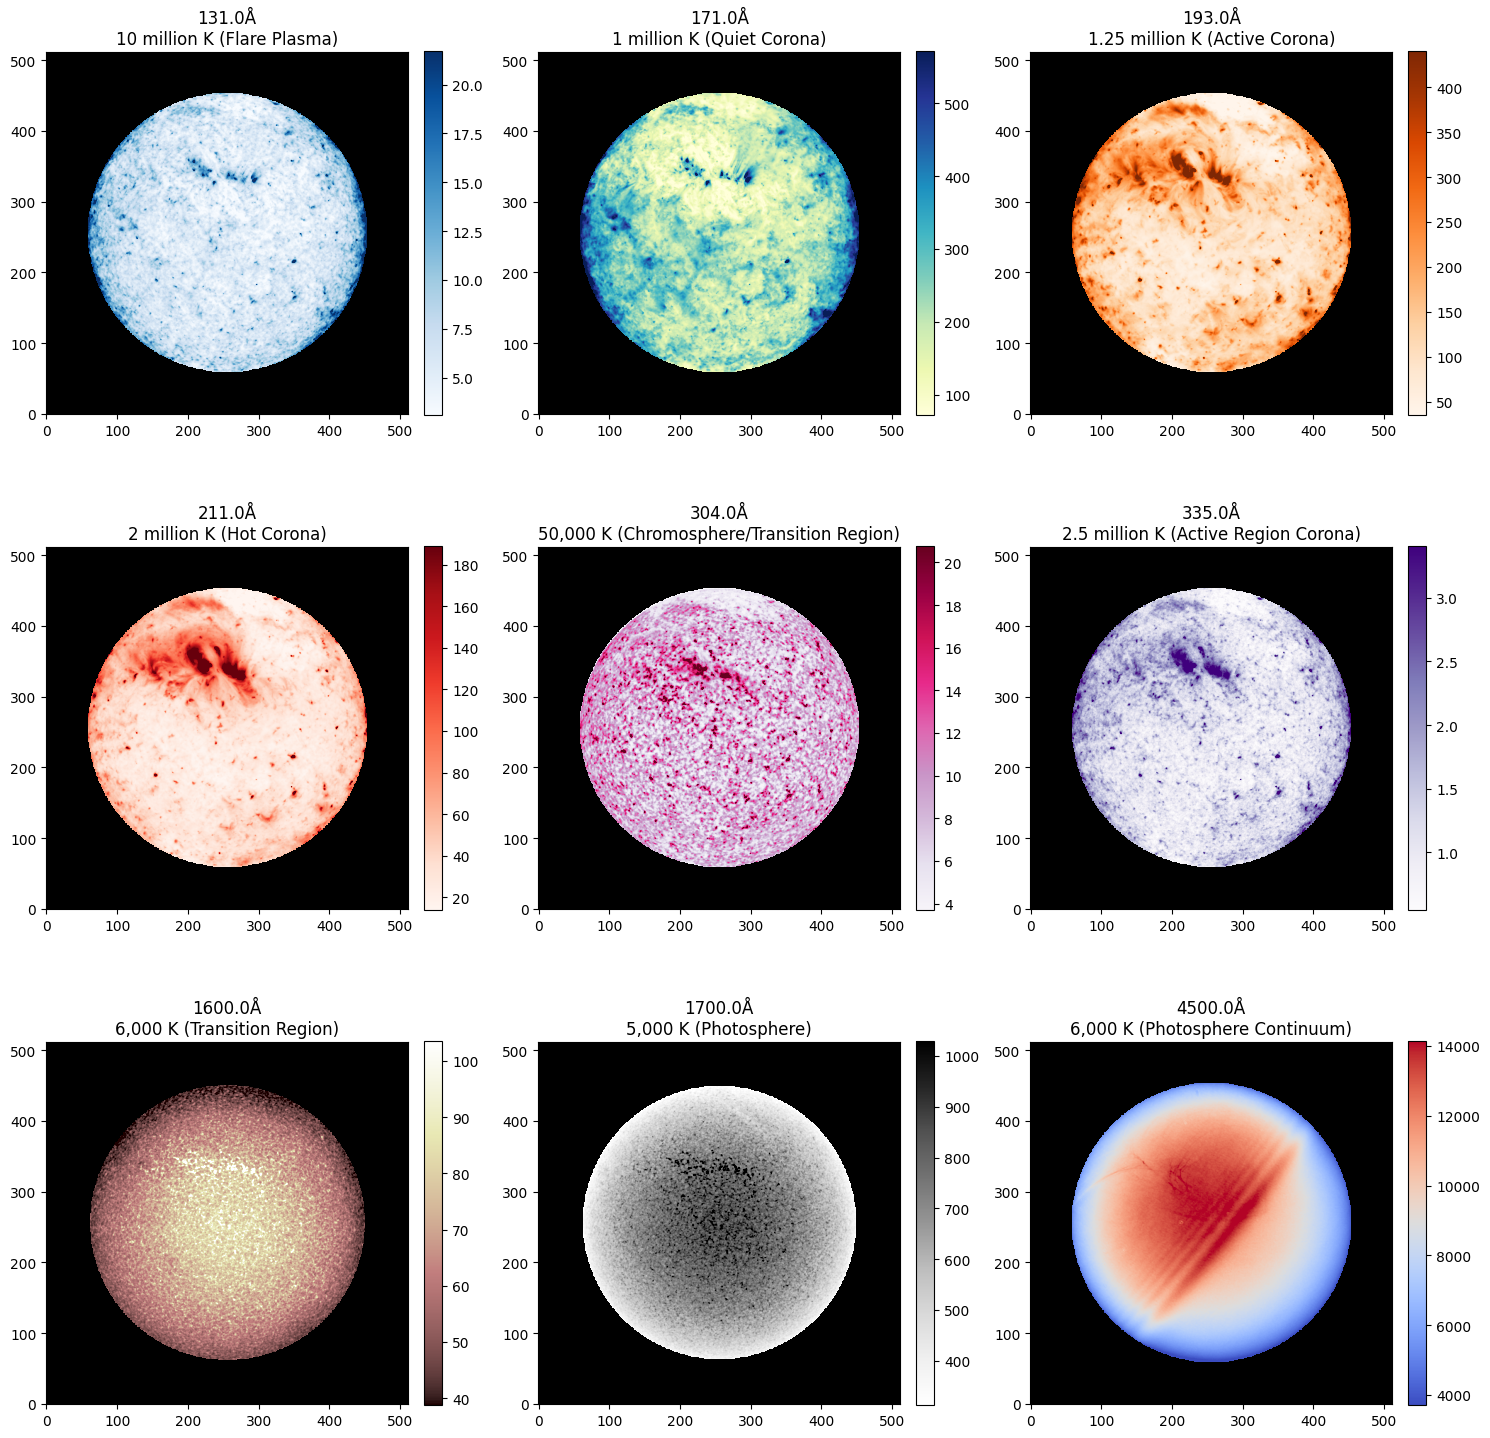

In [38]:
def plot_channel(ax: plt.Axes, channel: str,
                 masked_data: np.ndarray, 
                 channel_properties: dict):
    """
    Plot the processed channel data.

    Args:
        ax (plt.Axes): Matplotlib axis for plotting.
        channel (str): Name of the solar channel.
        masked_data (np.ndarray): Processed and masked image data.
        channel_properties (dict): Properties for each channel (e.g., colormap, description).
    """
    vmin, vmax = np.nanpercentile(masked_data, [1, 99])
    props = channel_properties.get(channel, {"cmap": "gray", "description": "Unknown"})
    ax.set_facecolor("black")
    im = ax.imshow(masked_data, origin="lower", cmap=props["cmap"], vmin=vmin, vmax=vmax)
    ax.set_title(f"{channel}\n{props['description']}", color="Black")
    plt.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)

# Crear figura para mostrar los canales
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()
fig.patch.set_facecolor("white")

# Procesar cada canal
for i, channel in enumerate(channel_properties.keys()):
    channel_dir = os.path.join(data, channel)
    try:
        # Cargar datos y metadatos
        channel_data, metadata = load_fits_data(channel_dir)
        print(f"Channel: {channel}, Data Stats: min={np.nanmin(channel_data)},
              max={np.nanmax(channel_data)}")
        
        # Crear máscara circular
        mask = create_circular_mask(channel_data, metadata)

        # Preprocesar la imagen
        masked_data = preprocess_image(channel_data, mask)
        # Verificar si los datos no están completamente enmascarados
        if np.isnan(masked_data).all():
            print(f"Channel {channel}: All data masked.")
            axes[i].set_title(f"{channel} (All Data Masked)", color="Black")
            axes[i].axis("off")
            continue

        # Graficar el canal
        plot_channel(axes[i], channel, masked_data, channel_properties)
    except (FileNotFoundError, ValueError) as e:
        print(f"Error processing channel {channel}: {e}")
        axes[i].set_title(f"{channel} (Error)", color="Blacck")
        axes[i].axis("off")

# Ajustar el diseño
plt.tight_layout()
plt.show()

Primero, necesitamos aplanar las imágenes enmascaradas para obtener un conjunto de datos de píxeles. También normalizaremos los datos para que estén en un rango adecuado para los métodos de detección de anomalías.

In [1]:
def prepare_data(masked_data):
    """
    Prepara los datos para la detección de anomalías.

    Args:
        masked_data (np.ndarray): Imagen enmascarada (2D).

    Returns:
        np.ndarray: Datos aplanados y normalizados.
    """
    # Aplanar la imagen enmascarada
    flattened_data = masked_data[~np.isnan(masked_data)].reshape(-1, 1)  # Eliminar NaN y aplanar
    
    # Normalizar los datos (escalar entre 0 y 1)
    flattened_data_normalized = (flattened_data - np.min(flattened_data)) / (np.max(flattened_data) - np.min(flattened_data))
    
    return flattened_data_normalized

##  Normalizing Flows


In [2]:
import torch
from nflows import distributions, flows, transforms

def detect_anomalies_normalizing_flows(data):
    """
    Detecta anomalías usando Normalizing Flows.

    Args:
        data (np.ndarray): Datos aplanados y normalizados.

    Returns:
        np.ndarray: Puntajes de anomalías (valores más altos indican mayor probabilidad de anomalía).
    """
    # Convertir los datos a un tensor de PyTorch
    data_tensor = torch.tensor(data, dtype=torch.float32)
    
    # Definir la transformación y la distribución base
    num_layers = 5
    hidden_features = 64
    transform = transforms.CompositeTransform([
        transforms.MaskedAffineAutoregressiveTransform(
            features=1,
            hidden_features=hidden_features,
            num_blocks=2,
            use_residual_blocks=False
        ) for _ in range(num_layers)
    ])
    base_distribution = distributions.StandardNormal(shape=[1])
    flow = flows.Flow(transform, base_distribution)
    
    # Entrenar el modelo (esto es un ejemplo simplificado)
    optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
    for _ in range(100):  # Número de épocas
        optimizer.zero_grad()
        loss = -flow.log_prob(data_tensor).mean()
        loss.backward()
        optimizer.step()
    
    # Calcular puntajes de anomalía (log-probabilidad negativa)
    anomaly_scores = -flow.log_prob(data_tensor).detach().numpy()
    
    return anomaly_scores

In [ ]:
def plot_anomalies(ax, masked_data, anomalies, method_name):
    """
    Grafica las anomalías detectadas en la imagen.

    Args:
        ax (plt.Axes): Eje para graficar.
        masked_data (np.ndarray): Imagen enmascarada.
        anomalies (np.ndarray): Etiquetas o puntajes de anomalías.
        method_name (str): Nombre del método usado.
    """
    # Crear una máscara de anomalías
    anomaly_mask = np.zeros_like(masked_data, dtype=bool)
    anomaly_mask[~np.isnan(masked_data)] = anomalies == -1  # Para Isolation Forest y LOF
    
    # Graficar la imagen original
    ax.imshow(masked_data, origin="lower", cmap="gray", vmin=np.nanpercentile(masked_data, 1), vmax=np.nanpercentile(masked_data, 99))
    
    # Superponer las anomalías
    ax.imshow(anomaly_mask, origin="lower", cmap="Reds", alpha=0.5)
    
    # Añadir título
    ax.set_title(f"{method_name}\nAnomalías Detectadas", color="white")
# Procesar cada canal
for i, channel in enumerate(channel_properties.keys()):
    channel_dir = os.path.join(data, channel)
    try:
        # Cargar datos y metadatos
        channel_data, metadata = load_fits_data(channel_dir)
        print(f"Channel: {channel}, Data Stats: min={np.nanmin(channel_data)}, max={np.nanmax(channel_data)}")
        
        # Crear máscara circular
        mask = create_circular_mask(channel_data, metadata)

        # Preprocesar la imagen
        masked_data = preprocess_image(channel_data, mask)

        # Verificar si los datos no están completamente enmascarados
        if np.isnan(masked_data).all():
            print(f"Channel {channel}: All data masked.")
            axes[i].set_title(f"{channel} (All Data Masked)", color="black")
            axes[i].axis("off")
            continue

        # Preparar los datos para la detección de anomalías
        flattened_data = prepare_data(masked_data)

        # Detectar anomalías usando Isolation Forest
        anomalies_iso_forest = detect_anomalies_isolation_forest(flattened_data)
        plot_anomalies(axes[i, 0], masked_data, anomalies_iso_forest, "Isolation Forest")

        # Detectar anomalías usando LOF
        anomalies_lof = detect_anomalies_lof(flattened_data)
        plot_anomalies(axes[i, 1], masked_data, anomalies_lof, "Local Outlier Factor")

        # Detectar anomalías usando Normalizing Flows
        anomaly_scores_nf = detect_anomalies_normalizing_flows(flattened_data)
        plot_anomalies(axes[i, 2], masked_data, anomaly_scores_nf > np.percentile(anomaly_scores_nf, 95), "Normalizing Flows")

    except (FileNotFoundError, ValueError) as e:
        print(f"Error processing channel {channel}: {e}")
        axes[i].set_title(f"{channel} (Error)", color="black")
        axes[i].axis("off")

# Ajustar el diseño
plt.tight_layout()
plt.show()